<a href="https://colab.research.google.com/github/aLehav/MLVideoDescriptionResearch/blob/main/BEATs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Link to BEATs Github](https://github.com/microsoft/unilm/tree/master/beats)

[Link to AudioSet](https://ieeexplore-ieee-org.libproxy2.usc.edu/stamp/stamp.jsp?tp=&arnumber=7952261)

In [1]:
!pip install boto3 --quiet
import io
import matplotlib.pyplot as plt
import pandas as pd
import math
import cv2
import torch
import torchaudio
import gc
import json
import os
import tarfile
import tempfile
import boto3
import matplotlib.pyplot as plt
import requests
from botocore import UNSIGNED
from botocore.config import Config
from IPython.display import Audio
!git clone https://github.com/microsoft/unilm.git --quiet
%cd unilm/beats
from Tokenizers import TokenizersConfig, Tokenizers
from BEATs import BEATs, BEATsConfig
%cd ../../
!git clone https://github.com/audioset/ontology.git --quiet
%cd ontology
f = open('ontology.json')
ontology = json.load(f)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd ../drive/MyDrive/video_summarization/
anno = pd.read_csv('ydata-tvsum50-anno.tsv', sep='\t', header=None)
!ls

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 10.1 MB/s eta 0:00:00
/content/unilm/beats
/content
/content/ontology
Mounted at /content/drive
/content/drive/MyDrive/video_summarization
91IHQYk1IQM.mp3					 ontology
91IHQYk1IQM.mp4					 qqR6AEXwxoQ.mp3
91IHQYk1IQM.wav					 qqR6AEXwxoQ.wav
BEATs_iter3_plus_AS2M_finetuned_on_AS2M_cpt2.pt  Tokenizer_iter3_plus_AS2M.pt
BEATs_iter3_plus_AS2M.pt			 ydata-tvsum50-anno.tsv


In [2]:
checkpoint = torch.load('BEATs_iter3_plus_AS2M_finetuned_on_AS2M_cpt2.pt')
cfg = BEATsConfig(checkpoint['cfg'])
BEATs_model = BEATs(cfg)
BEATs_model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [21]:
def get_top_k_labels(audio_input_16khz, k):
  audio_length = audio_input_16khz.shape[1]
  audio_dim = audio_input_16khz.shape[0]
  padding_mask = torch.zeros(audio_dim,audio_length).bool()

  probs = BEATs_model.extract_features(audio_input_16khz, padding_mask=padding_mask)[0]
  for i, (top5_label_prob, top5_label_idx) in enumerate(zip(*probs.topk(k=k))):
      top5_label = [checkpoint['label_dict'][label_idx.item()] for label_idx in top5_label_idx]
      return (top5_label, top5_label_prob)

def plot_2_cols(df, lab1, lab2, kind='line'):
  ax = df.plot(y=lab1, legend=False, kind=kind)
  ax2 = ax.twinx()
  df.plot(y=lab2, ax=ax2, legend=False, color="c", kind=kind)
  ax.figure.legend()
  plt.show()

class Video:
  def __init__(self, vid_name):
    self.name = vid_name
    meta = torchaudio.info(vid_name + '.wav') # load in wav fie for number of frames
    self.num_frames = meta.num_frames # get number of frames total
    self.waveform, self.sample_rate = torchaudio.load(vid_name + '.wav')
    self.slice_waveform() # get cut up waveforms
    cap = cv2.VideoCapture(vid_name+'.mp4')
    self.fps = cap.get(cv2.CAP_PROP_FPS) # get fps through openCV
  def slice_waveform(self):
    scaler = 2*self.sample_rate
    i_range = range(math.ceil(self.num_frames/scaler))
    def bot_slice(i):
      return i*scaler
    def top_slice(i):
      return min((i+1)*scaler, self.num_frames)
    self.waveforms = [self.waveform[:,bot_slice(i):top_slice(i)] for i in i_range]
    self.num_slices = len(self.waveforms)
  def get_k_labels(self, k):
    self.k = k
    self.labels = [get_top_k_labels(wave, k) for wave in self.waveforms]
    label_set = [label[0] for label in self.labels]
    ont_index = lambda label: next((i for i, item in enumerate(ontology) if item['id'] == label), -1)
    a = lambda x: [ontology[ont_index(i)]['name'] for i in x]
    self.english_labels = pd.DataFrame([a(label) for label in label_set])
  def get_scores(self):
    vid_anno = anno.loc[anno[0] == self.name]
    a = lambda x: [int(i) for i in x[1][2].split(',')]
    b = lambda x: pd.DataFrame([a(i) for i in vid_anno.iterrows()])
    # def annotation_string_to_numerics(vid_anno): 
      # return pd.DataFrame([a(annotation) for annotation in vid_anno.iterrows()])
    self.ratings = b(vid_anno)
    scaler = 2*self.fps
    i_range = range(1,math.ceil(self.ratings.shape[1]/scaler))
    def bot_slice(i):
      return int(i*scaler)
    # def top_slice(i):
      # return min((i+1)*scaler, ratings.shape[1])

    abs_scorer = lambda i: sum(abs(self.ratings[bot_slice(i)] - self.ratings[bot_slice(i)+1]))
    abs_score_changes = pd.DataFrame([abs_scorer(i) for i in i_range])

    scorer = lambda i: sum(self.ratings[bot_slice(i)] - self.ratings[bot_slice(i)+1])
    score_changes = pd.DataFrame([scorer(i) for i in i_range])

    changes = pd.concat([abs_score_changes, score_changes], axis=1)
    changes.columns = ['Abs Score','Score']
    self.changes = changes

    a = lambda ind, df: pd.Series(df.iloc[ind])
    b = lambda ind, df: len(a(ind, df)) - sum([(item in a(ind+1, df).unique()) for item in a(ind, df)]) 
    label_changes = lambda df: pd.DataFrame([b(i, df) for i in range(df.shape[0]-1)])
    for i in range(1,self.k+1):
      lab_changes = label_changes(self.english_labels.iloc[:,0:i])
      self.changes[str(i)+'Labels'] = lab_changes

    
  # def get_scores(self)
  

In [6]:
a = Video(vid_name='91IHQYk1IQM')
a.get_k_labels(5)
a.get_scores()

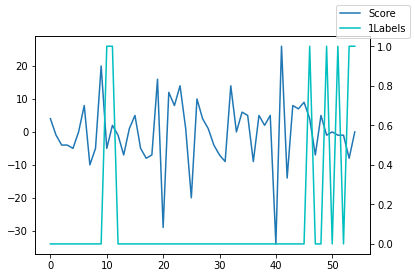

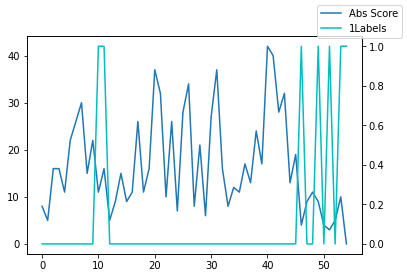

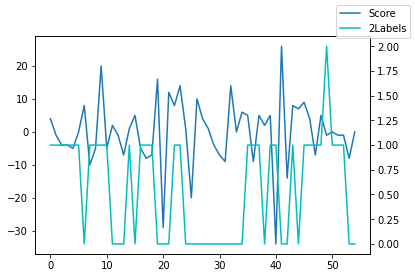

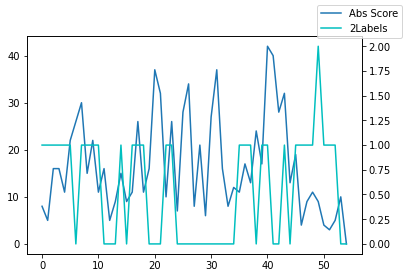

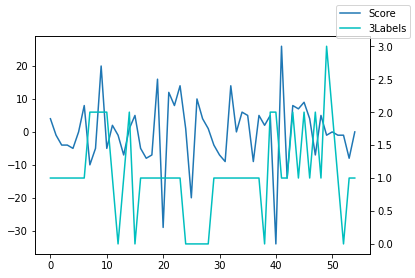

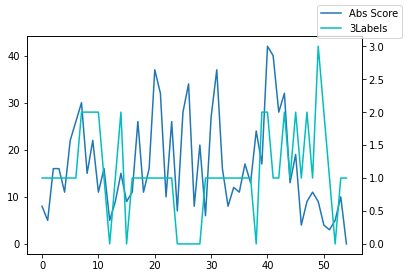

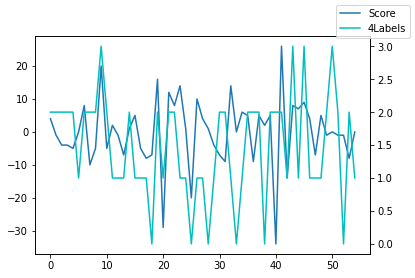

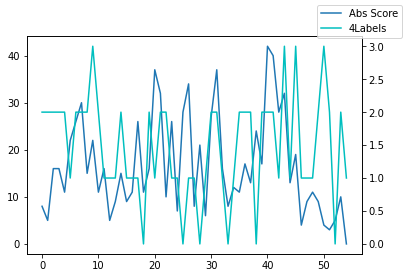

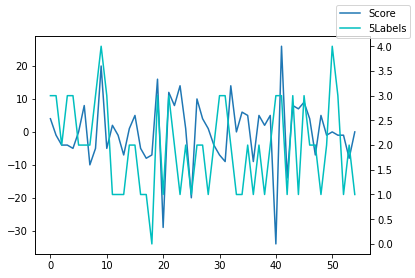

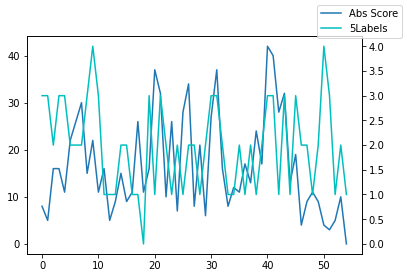

In [28]:
for i in range(1, a.k+1):
  plot_2_cols(a.changes, 'Score', str(i)+'Labels', kind='line')
  plot_2_cols(a.changes, 'Abs Score', str(i)+'Labels')

<AxesSubplot:ylabel='Abs Score'>

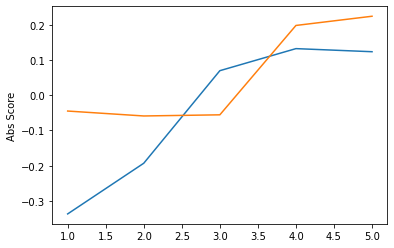

In [30]:
import seaborn as sn
sn.lineplot(y = a.changes.corr()['Abs Score'][2:], x = range(1, a.k+1))
sn.lineplot(y = a.changes.corr()['Score'][2:], x = range(1, a.k+1))
